In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, roc_auc_score, log_loss
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

df = pd.read_csv('data/Cardiovascular_Diseases_Risk_Prediction_Dataset.csv')

y = df['Heart_Disease']
X = df.drop('Heart_Disease', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12, stratify=y)

# Transform Target column to 1's and 0's
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

num_cols = [
    'Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption',
    'Fruit_Consumption', 'Green_Vegetables_Consumption',
    'FriedPotato_Consumption'
]
ord_cols = ['General_Health', 'Checkup', 'Age_Category']
dum_cols = [
    'Exercise', 'Skin_Cancer', 'Depression', 'Arthritis', 'Other_Cancer',
    'Smoking_History', 'Sex', 'Diabetes'
]

health = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
check = [
    'Never', '5 or more years ago', 'Within the past 5 years',
    'Within the past 2 years', 'Within the past year'
]
age = [
    '18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59',
    '60-64', '65-69', '70-74', '75-79', '80+'
]

col_transformer = ColumnTransformer(transformers=[
    ('oe', OrdinalEncoder(categories=[health, check, age]), ord_cols),
    ('ohe', OneHotEncoder(), dum_cols)
],
                                    remainder="passthrough")



def data_prep(X_train, y_train, X_test, y_test, smote=True, scale=True):
    if smote & scale:
        pipe = ImPipeline(steps=[('ct',col_transformer),
                         ('ss', StandardScaler()),
                         ('sm', SMOTE(random_state=42))])
        X_train_resampled, y_train_resampled = pipe.fit_resample(X_train,y_train)
        X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=pipe.get_feature_names_out())
        X_test_scaled = pd.DataFrame(pipe[:-1].transform(X_test), columns=pipe.get_feature_names_out())
        return X_train_resampled_df, y_train_resampled, X_test_scaled, y_test
    elif smote:
        pipe = ImPipeline(steps=[('ct',col_transformer),
                         ('sm', SMOTE(random_state=42))])
        X_train_resamp, y_train_resamp = pipe.fit_resample(X_train,y_train)
        X_train_resamp_df = pd.DataFrame(X_train_resamp, columns=pipe.get_feature_names_out())
        X_test_transformed = pd.DataFrame(pipe[:-1].transform(X_test), columns=pipe.get_feature_names_out())
        return X_train_resamp_df, y_train_resamp, X_test_transformed, y_test
    elif scale:
        pipe = Pipeline(steps=[('col_transformer', col_transformer),
                               ('ss', StandardScaler())])
        pipe.fit(X_train)
        X_train_scaled = pd.DataFrame(pipe.transform(X_train), 
                                      columns=pipe.get_feature_names_out(),
                                      index=X_train.index)
        X_test_scaled = pd.DataFrame(pipe.transform(X_test), 
                                     columns=pipe.get_feature_names_out(),
                                     index= X_test.index)
        return X_train_scaled, y_train, X_test_scaled, y_test
    else:
        pipe = Pipeline(steps=[('col_transformer', col_transformer)])
        pipe.fit(X_train)
        X_train_transformed = pd.DataFrame(pipe.transform(X_train),
                                columns=pipe.get_feature_names_out(),
                                index=X_train.index)
        X_test_transformed = pd.DataFrame(pipe.transform(X_test),
                                columns=pipe.get_feature_names_out(),
                                index=X_test.index)
        return X_train_transformed, y_train, X_test_transformed, y_test

In [ ]:
X_tr, y_tr, X_ts, y_ts = data_prep(X_train, y_train, X_test, y_test, smote=False, scale=True)

classifiers = {
    "DummyClassifier": DummyClassifier(strategy='most_frequent', random_state=12),
    "LogisticRegression": LogisticRegression(random_state=12),  
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=12),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "GaussianNB": GaussianNB(),
    "RandomForestClassifier": RandomForestClassifier(random_state=12),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=12),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=12),
    "XGBClassifier": XGBClassifier(random_state=12)
}

models_list = []

for key in classifiers:
    print('*',key)
    classifier = classifiers[key]
    model = classifier.fit(X_tr, y_tr)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
    score = cross_validate(model,
                           X_tr,
                           y_tr,
                           scoring=['f1', 'neg_log_loss'],
                           cv=cv,
                           n_jobs=3)
    f1 = score['test_f1'].mean()
    log_loss = -1 * score['test_neg_log_loss'].mean()
    row = [key, f1, log_loss]
    models_list.append(row)
models_df = pd.DataFrame(models_list,columns=['model', 'F1', 'log_loss'])
models_df

In [4]:
X_tr, y_tr, X_ts, y_ts = data_prep(X_train, y_train, X_test, y_test, smote=True, scale=True)

classifiers = {
    "DummyClassifier": DummyClassifier(strategy='most_frequent', random_state=12),
    "LogisticRegression": LogisticRegression(solver = 'lbfgs', max_iter=1000, random_state=12),
    "XGBClassifier": XGBClassifier(random_state=12),
    "KNeighborsClassifier": KNeighborsClassifier(),    
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=12),
    "RandomForestClassifier": RandomForestClassifier(random_state=12),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=12),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=12),
    "GaussianNB": GaussianNB()
}

models_list = []

for key in classifiers:
    print('*',key)
    classifier = classifiers[key]
    model = classifier.fit(X_tr, y_tr)
    score = cross_validate(model, X_tr, y_tr, scoring=['roc_auc'], cv=5, n_jobs=-2)
    score_train = score['test_roc_auc'].mean()
    score_test = roc_auc_score(y_ts, model.predict(X_ts))
    row = [key, score_train, score_test]
    models_list.append(row)
models_df = pd.DataFrame(models_list,columns=['model', 'score_train', 'score_test'])
models_df.sort_values('score_test', ascending = False)

* DummyClassifier
* LogisticRegression
* XGBClassifier
* KNeighborsClassifier
* DecisionTreeClassifier
* RandomForestClassifier
* AdaBoostClassifier
* GradientBoostingClassifier
* GaussianNB


,model,score_train,score_test
1,LogisticRegression,0.843990,0.761050
8,GaussianNB,0.790284,0.713645
6,AdaBoostClassifier,0.939363,0.701286
3,KNeighborsClassifier,0.952953,0.661176
7,GradientBoostingClassifier,0.974639,0.638022
4,DecisionTreeClassifier,0.912724,0.580929
5,RandomForestClassifier,0.992919,0.573562
2,XGBClassifier,0.980822,0.527781
0,DummyClassifier,0.500000,0.500000


In [34]:
classifiers = {
    "DummyClassifier": DummyClassifier(strategy='most_frequent', random_state=12),
    "LogisticRegression": LogisticRegression(solver = 'lbfgs', max_iter=1000, random_state=12),
    "XGBClassifier": XGBClassifier(random_state=12),
    "KNeighborsClassifier": KNeighborsClassifier(),    
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=12),
    "RandomForestClassifier": RandomForestClassifier(random_state=12),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=12),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=12),
    "GaussianNB": GaussianNB()
}

models_list = []

for key in classifiers:
    print('*',key)
    classifier = classifiers[key]
    model = classifier.fit(X_tr, y_tr)
    score = cross_validate(model, X_tr, y_tr, scoring=['accuracy', 'f1', 'neg_log_loss'], cv=5)
    f1 = score['test_f1'].mean()
    log_loss = -1 * score['test_neg_log_loss'].mean()
    row = [key, f1, log_loss]
    models_list.append(row)
models_df = pd.DataFrame(models_list,columns=['model', 'F1', 'log_loss'])
models_df 

    
    
    

[CV 3/5] END ......................xbg__eta=0.3;, score=0.085 total time= 1.2min
[CV 4/5] END ......................xbg__eta=0.3;, score=0.086 total time=  54.3s
[CV 2/5] END ......................xbg__eta=0.3;, score=0.093 total time= 1.2min
[CV 5/5] END ......................xbg__eta=0.3;, score=0.093 total time=  54.4s


0.9387810165573264

In [39]:
f1_score(y_test,clf.predict(X_ts))


0.10895162434387856

In [13]:
# XGBClassifier 1
xgb_pipe = ImPipeline(steps=[('ct', col_transformer),
                             ('sm', SMOTE(random_state=12)),
                             ('ss', StandardScaler()),
                             ('xbg', XGBClassifier(random_state=12, tree_method = 'hist'))])
params = {
    'xbg__eta': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4], # default=0.3 [0,1]
    'xbg__max_depth': range(1,12), # default=6 [0,∞]
    'xbg__min_child_weight': range(1,10), 
    'xbg__subsample': np.linspace(0,1), 
    'xbg__colsample_bytree': np.linspace(0,1), 
    'xbg__n_estimators': range(50,500,50),
    'xbg__gamma' : [0, 1, 10, 100, 1000], 
    'sm__k_neighbors': [3, 5, 9]}
gs = RandomizedSearchCV(xgb_pipe, param_distributions=params, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=3, 
                     verbose=4, random_state=12)
gs.fit(X_train, y_train)
rs1 = pd.DataFrame(gs.cv_results_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [19]:
test = rs1.sort_values('rank_test_score')

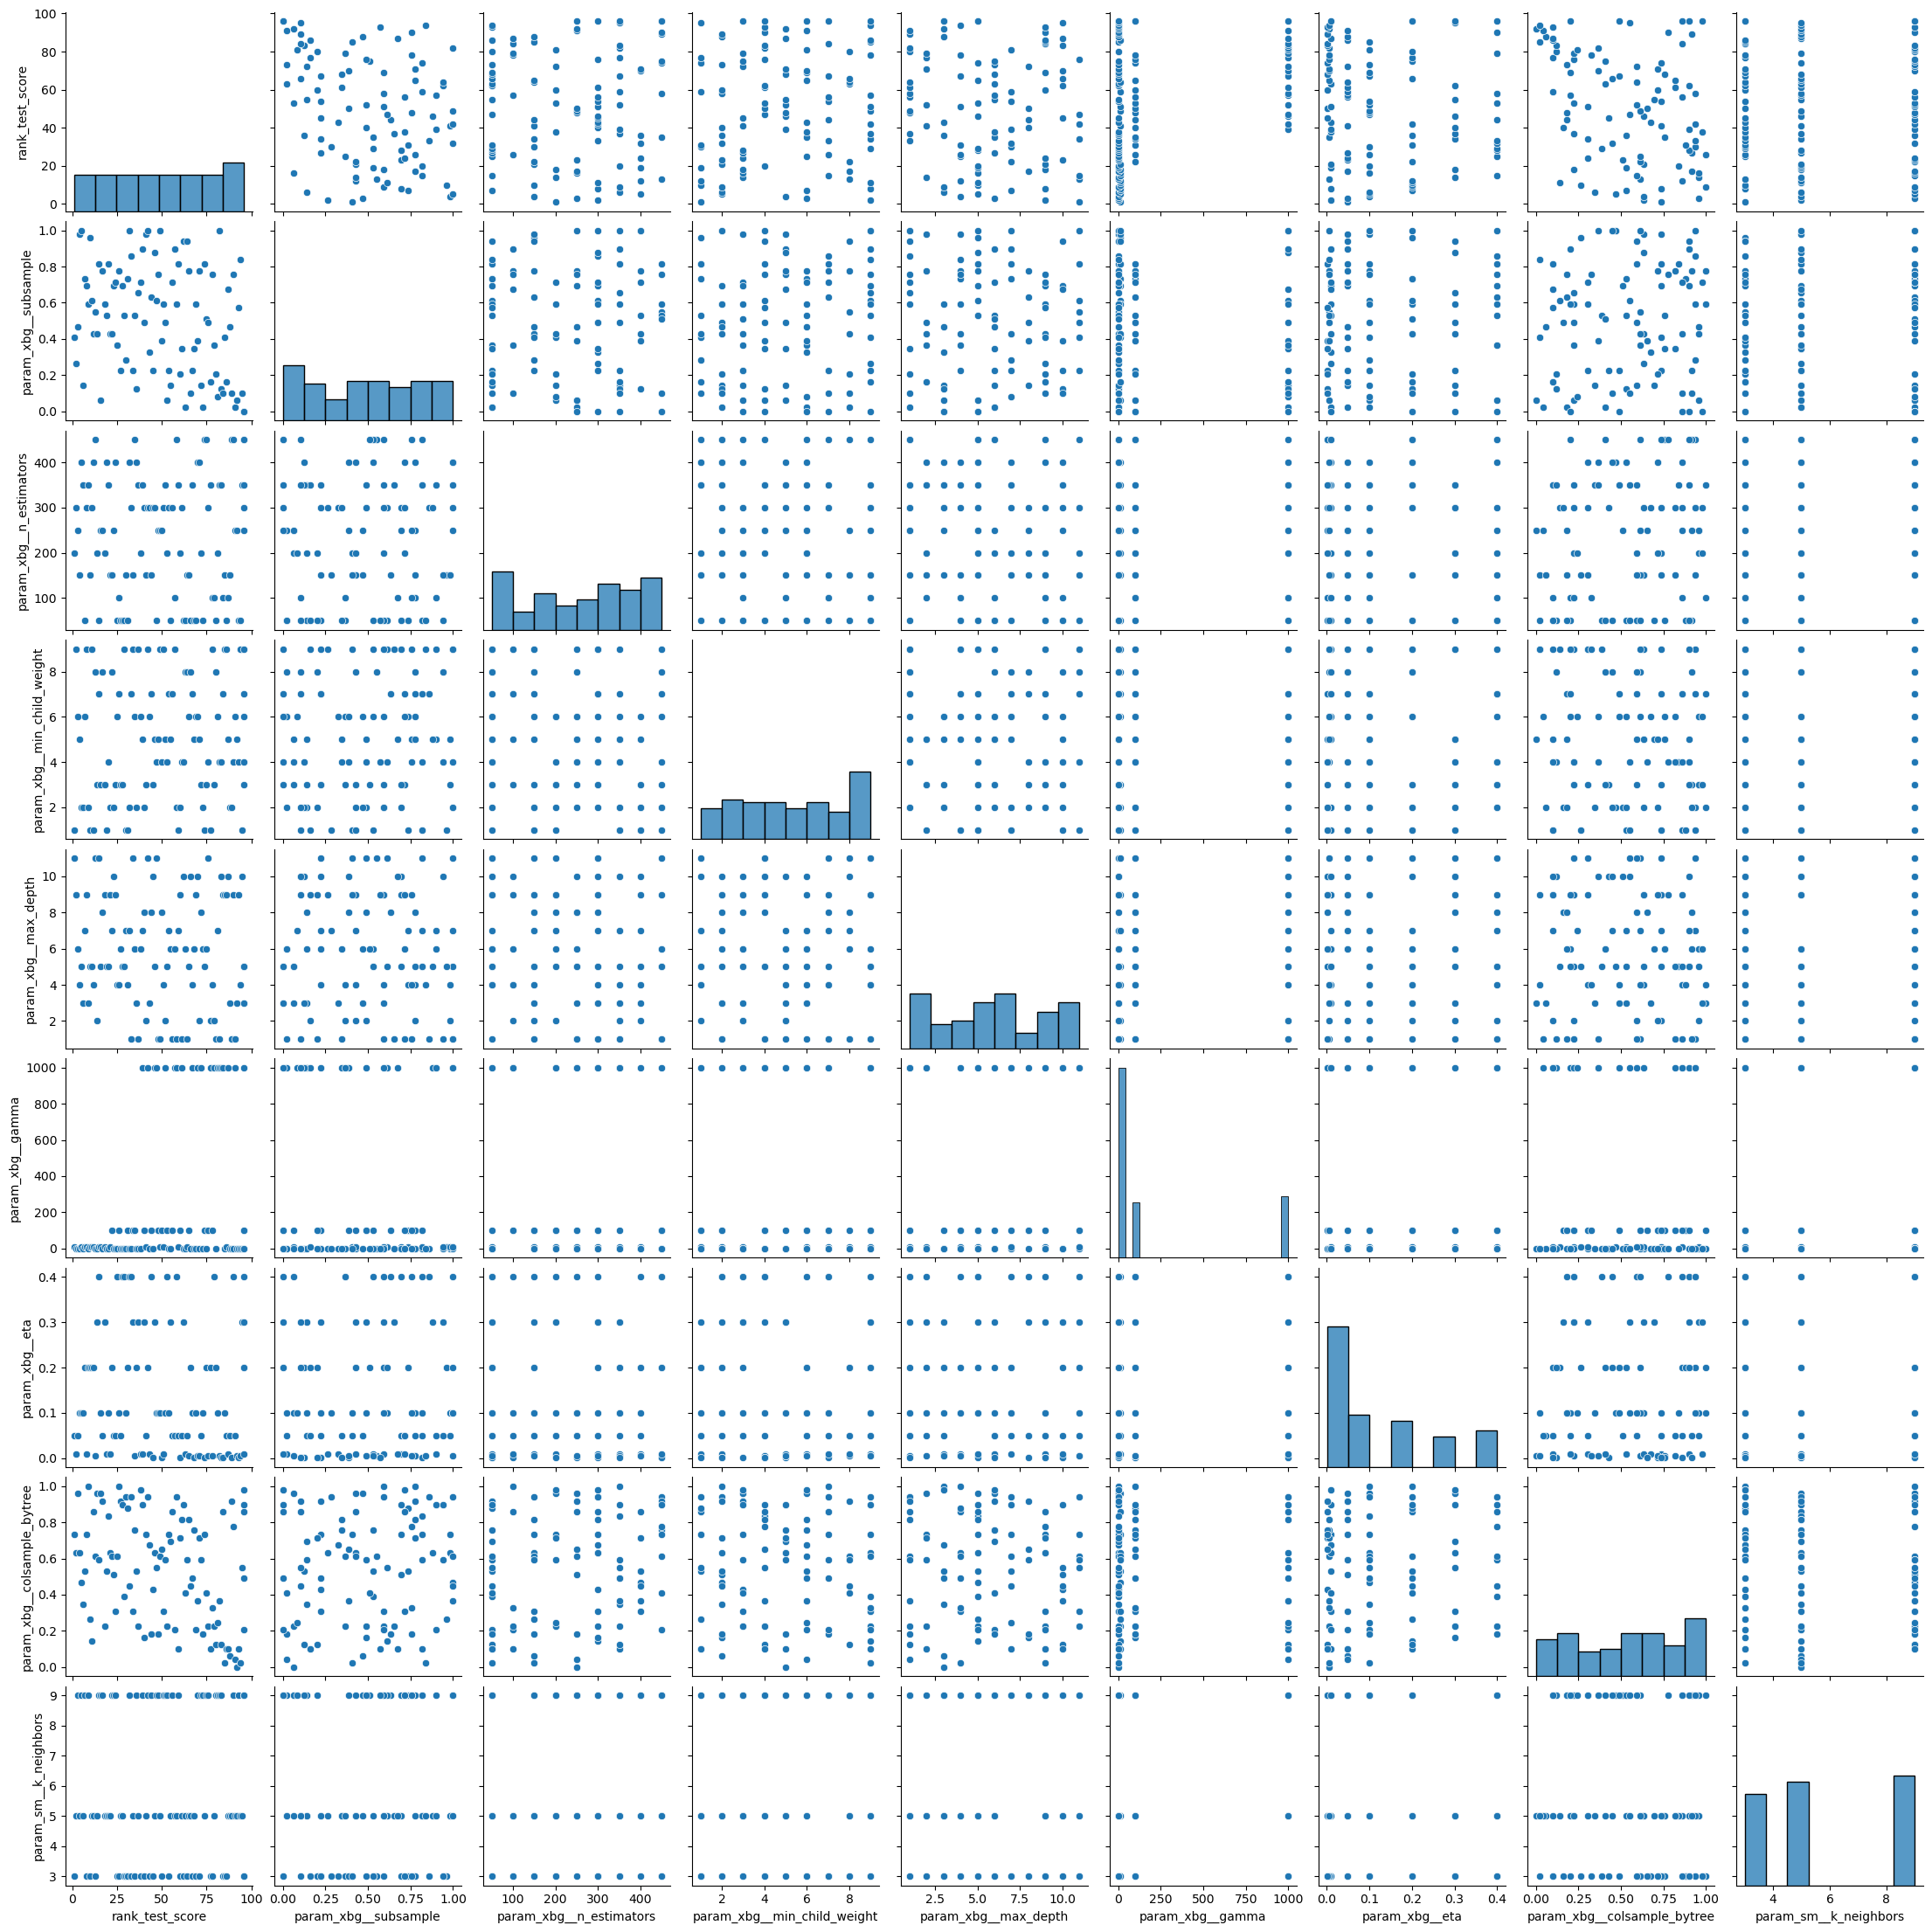

In [22]:
import seaborn as sns
sns.pairplot(test[['rank_test_score', 'param_xbg__subsample', 'param_xbg__n_estimators',
       'param_xbg__min_child_weight', 'param_xbg__max_depth',
       'param_xbg__gamma', 'param_xbg__eta', 'param_xbg__colsample_bytree',
       'param_sm__k_neighbors']])

In [21]:
test.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_xbg__subsample', 'param_xbg__n_estimators',
       'param_xbg__min_child_weight', 'param_xbg__max_depth',
       'param_xbg__gamma', 'param_xbg__eta', 'param_xbg__colsample_bytree',
       'param_sm__k_neighbors', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')